In [1]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila, FakeToronto, FakeJakartaV2
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import scipy
import os
import sys
import itertools
from numpy.random import Generator, PCG64
from datetime import date
import pathlib
import inspect
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..'))
module_path = os.path.abspath(os.path.join(module_path, '..')) # qrc_surrogate
sys.path.insert(1, module_path)
plot_path = f'{module_path}/plots_narma'

from src.feedforward import QExtremeLearningMachine, CPolynomialFeedforward
from src.rewinding import QRewindingRC, QRewindingStatevectorRC
from src.data import DataSource

sns.set_style('whitegrid')
palette = 'muted' # muted deep colorblind dark
colors = sns.color_palette(palette).as_hex() 
sns.set_palette(sns.color_palette(palette))
# colors_sequential = sns.color_palette("viridis").as_hex()
colors_sequential = sns.color_palette("viridis")

In [2]:
rseed = 40

# Error Source

Here we show that the primary error source is the error accumulation (drift) over time.
This is because the ELM takes in it's own previous prediction as input, and so any error.

nrmse_train:    5.89e-04
nrmse_val:      6.12e-03
corr_train:     1.00e+00
corr_val:       9.72e-01


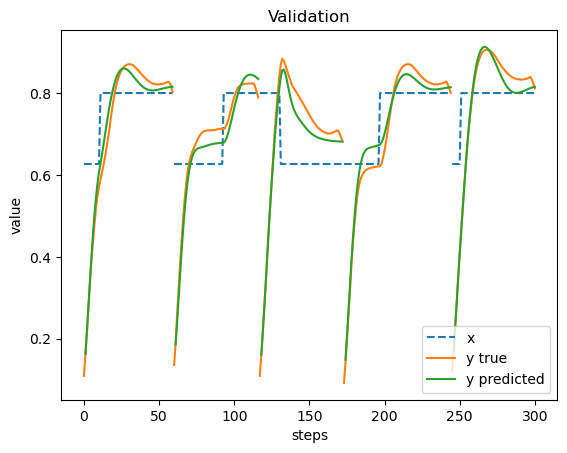

In [3]:
data = DataSource(xtype='reactor', xnorm='norm', ynorm='norm', rseed_data=rseed)
base = CPolynomialFeedforward(poly_degree=3, regression_model='ridge', regression_alpha=0.001)
base.run(data)

base.print_results()

# print(base.dimf) # 119

# base.plot_train(px=True)
base.plot_val(px=True)

nrmse_train:    1.51e-03
nrmse_val:      8.94e-03
corr_train:     9.98e-01
corr_val:       9.37e-01


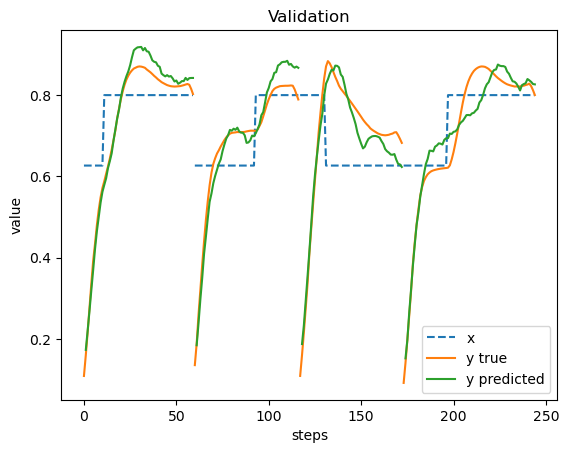

In [4]:


data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=rseed)

qrff = QExtremeLearningMachine(nqubits=5, measaxes=3, qctype='ising', ftype=4)
qrff.run(data)

qrff.print_results()

# qrff.plot_train(nepisodes=4)
qrff.plot_val(nepisodes=4)
# qrff.qc.draw('mpl')

## Classical Benchmark

We start with the classical benchmark, since it is the simpler to understand and has the same problem as the ELM.

nrmse_train:    5.89e-04
nrmse_val:      6.22e-03
corr_train:     1.00e+00
corr_val:       9.73e-01


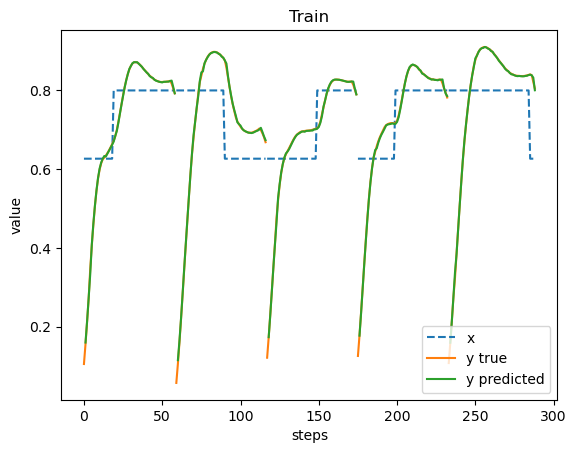

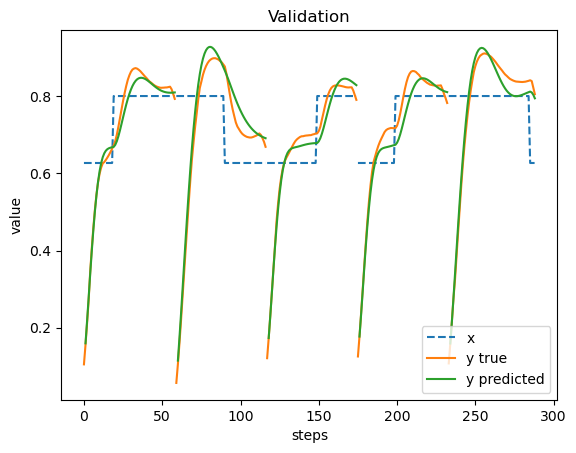

In [5]:
# training data = validation data
# -> accumulating error / drift because of recurrent structure 
# (use past outputs as future inputs)

data = DataSource(xtype='reactor', xnorm='norm', ynorm='norm', rseed_data=rseed, train_equal_val=True)
base = CPolynomialFeedforward(poly_degree=3, regression_model='ridge', regression_alpha=0.001)
base.run(data)

base.print_results()

base.plot_train(px=True)
base.plot_val(px=True)

Validation error = Train error: True
nrmse_train:    5.89e-04
nrmse_val:      5.89e-04
corr_train:     1.00e+00
corr_val:       1.00e+00


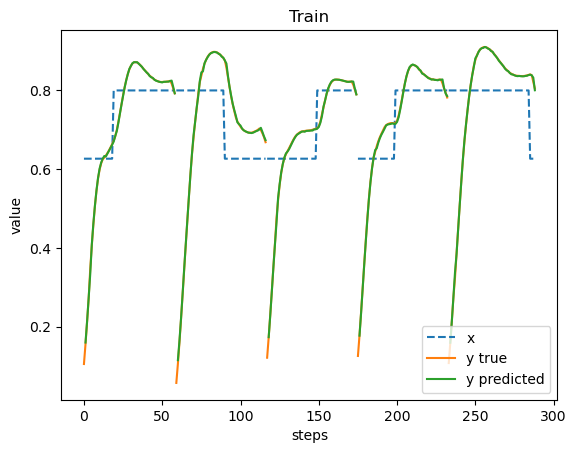

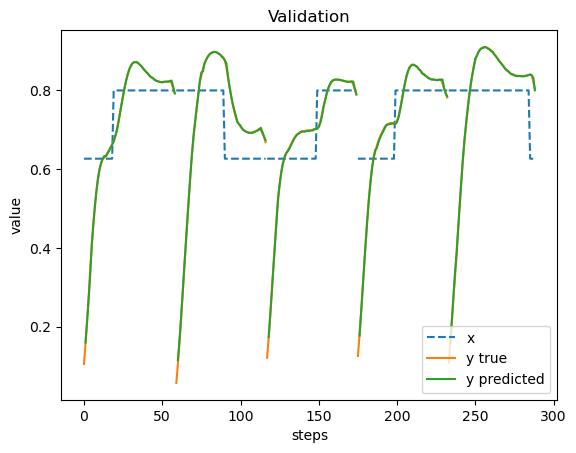

In [6]:
# training data = validation data, and using true past outputs as inputs
# -> irreducable error due to noise or statistical fluctuations (e.g. in circuit compilation or fitter)

data = DataSource(xtype='reactor', xnorm='norm', ynorm='norm', rseed_data=rseed, train_equal_val=True)
base = CPolynomialFeedforward(poly_degree=3, regression_model='ridge', regression_alpha=0.001, use_true_y_in_val=True)
base.run(data)

base.print_results()

base.plot_train(px=True)
base.plot_val(px=True)

Validation error = Train error: False
nrmse_train:    5.89e-04
nrmse_val:      5.75e-04
corr_train:     1.00e+00
corr_val:       1.00e+00


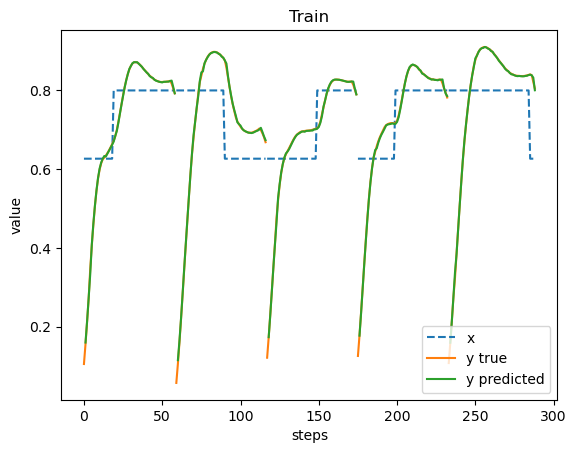

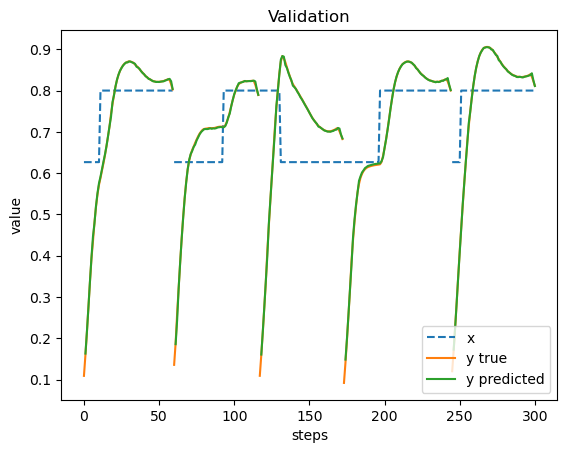

In [7]:
# using true past outputs as inputs (but on different training / validation data)
# -> model error (ability to predict next step)

data = DataSource(xtype='reactor', xnorm='norm', ynorm='norm', rseed_data=rseed)
base = CPolynomialFeedforward(poly_degree=3, regression_model='ridge', regression_alpha=0.001, use_true_y_in_val=True)
base.run(data)

base.print_results()

base.plot_train(px=True)
base.plot_val(px=True)

## QExtremeLearningMachine

nrmse_train:    1.46e-03
nrmse_val:      8.56e-03
corr_train:     9.98e-01
corr_val:       9.43e-01


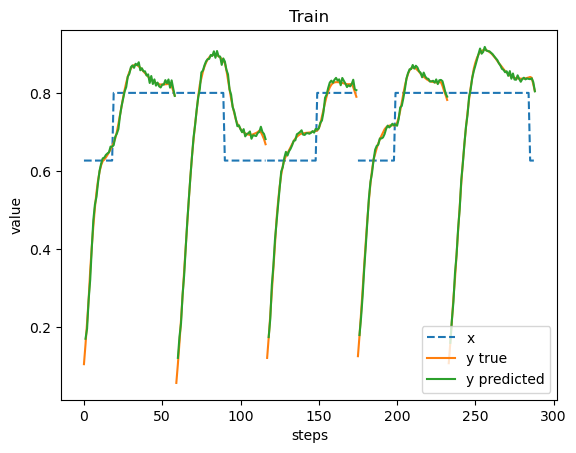

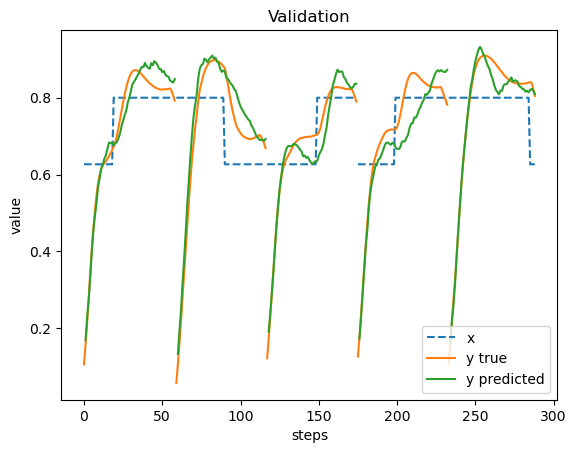

In [8]:
# training data = validation data
# -> accumulating error / drift because of recurrent structure 
# (use past outputs as future inputs)

data = DataSource(xtype='reactor', xnorm='norm', ynorm='norm', rseed_data=rseed, train_equal_val=True)

qrff = QExtremeLearningMachine(nqubits=5, measaxes=3, qctype='ising')
qrff.run(data)

qrff.print_results()

qrff.plot_train(px=True)
qrff.plot_val(px=True)

Validation error = Train error: False
nrmse_train:    1.51e-03
nrmse_val:      1.53e-03
corr_train:     9.98e-01
corr_val:       9.98e-01


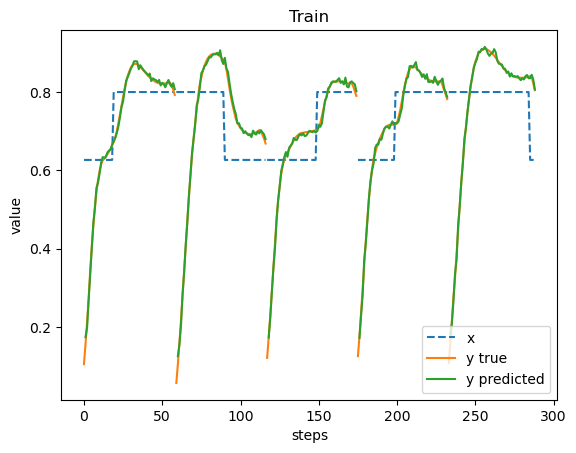

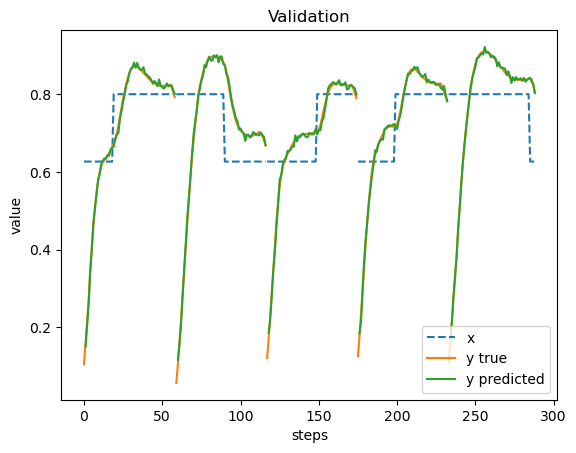

In [9]:
# training data = validation data, and using true past outputs as inputs
# -> irreducable error due to noise or statistical fluctuations (e.g. in circuit compilation or fitter)

data = DataSource(xtype='reactor', xnorm='norm', ynorm='norm', rseed_data=rseed, train_equal_val=True)

qrff = QExtremeLearningMachine(nqubits=5, measaxes=3, qctype='ising', use_true_y_in_val=True)
qrff.run(data)

qrff.print_results()

qrff.plot_train(px=True)
qrff.plot_val(px=True)

Validation error = Train error: False
nrmse_train:    1.49e-03
nrmse_val:      1.47e-03
corr_train:     9.98e-01
corr_val:       9.98e-01


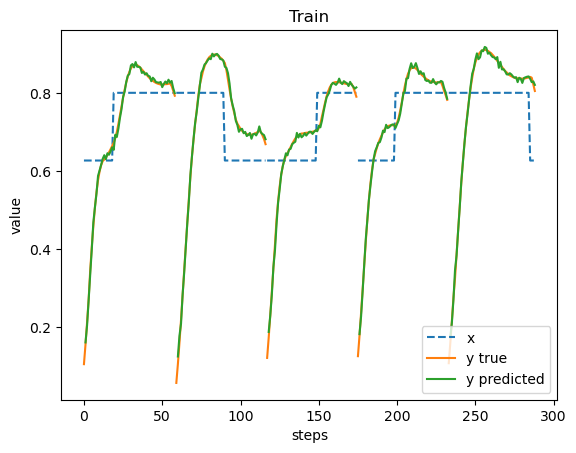

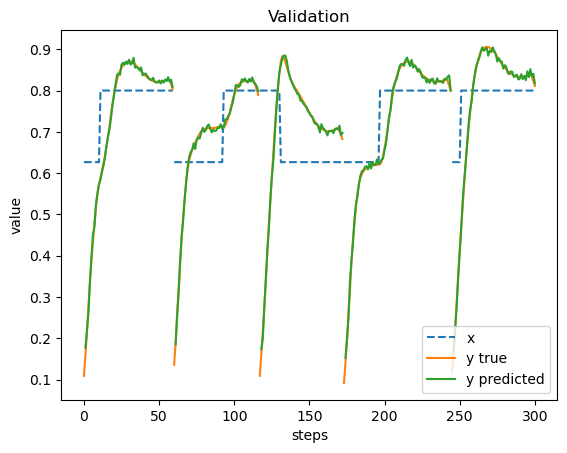

In [10]:
# # using true past outputs as inputs (but on different training / validation data)
# # -> model error

data = DataSource(xtype='reactor',xnorm='norm', ynorm='norm', rseed_data=rseed)

qrff = QExtremeLearningMachine(nqubits=5, measaxes=3, qctype='ising', use_true_y_in_val=True)
qrff.run(data)

qrff.print_results()

qrff.plot_train(px=True)
qrff.plot_val(px=True)